In [15]:
# #!/usr/bin/env python3
# # -*- coding: utf-8 -*-
# """
# Created on Tue Apr 23 23:16:42 2019

# @author: malavikavijayendravasist
# """

%load_ext autoreload
%autoreload 2

import tensorflow
from tensorflow.python.keras import layers 
from tensorflow.python.keras.losses import categorical_crossentropy
from tensorflow.python.keras.callbacks import TensorBoard
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.python.keras import backend
from tensorflow.python.keras.callbacks import ModelCheckpoint
from tensorflow.keras.metrics import top_k_categorical_accuracy 
from tensorflow.keras.models import load_model

from keras.utils import CustomObjectScope
from sklearn.metrics import confusion_matrix

import time
import numpy as np
import os
import h5py


#from keras.initializers import glorot_uniform

from data_classes import data_classes
from converting_images_to_TFRecords_ import converting_to_TFRecords as convertingTF
#from tfrecords import converting_to_TFRecords as Ctfrecords
from extracting_images_from_TFRecords_ import extracting_TFRecords as extractTF
#from extracting_ratio_records import  extracting_TFRecords as Ctfextract
from networkss import networks
from plot_confusion_matrix import ConfusionMatrix


sess = tensorflow.Session()

#training in Titan- /home/vasist/code/



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [16]:
class All: 
    
    def __init__(self, feature=None,pic_path=None,feature_values=None,DCfolder=None,epochs=None,batch_size=None,nclasses=None,dims=None,TBfolder=None,name=""):
        self.name = name
        self.feature='Size Ratio' #'Mass Ratio',
        self.feature_values=[]
        self.pic_path='/Users/malavikavijayendravasist/Desktop/mt2/handpicked_images/' #'/home/vasist/images/'
        self.DCfolder='/Users/malavikavijayendravasist/Desktop/mt2/data_classes/data_classes_trial/'#'/home/vasist/data_classes/'
        #self.TFRecord='/home/vasist/TFRecords/data_classes/'
        self.TFRecord='/Users/malavikavijayendravasist/Desktop/mt2/TFRecords/trial/'#'/home/vasist/TFRecords/ratio/'
        self.feat=[]    # array of features of all the images in the same order as the images
        self.nepochs=5
        self.batch_size=5
        self.nclasses=10
        self.dims=[224,224,3]
        self.TBfolder='/Users/malavikavijayendravasist/Desktop/mt2/Tensorboard/trial/'#'/home/vasist/Tensorboard/data_classes/'
        self.CPfolder='/Users/malavikavijayendravasist/Desktop/mt2/Checkpoints/trial/'#'/home/vasist/Checkpoints/data_classes/'
        self.Modelfolder='/Users/malavikavijayendravasist/Desktop/mt2/Models/trial/'#'/home/vasist/Models/data_classes/'
        self.network_name='mnist' #resnet50/mnist
        
        
    def Feature(self):
        
        images = os.listdir(self.pic_path)
        images=np.asarray(images)

        indices= np.random.choice(np.arange(len(images)),100) #len(images)


        redshift=[]
        merger=[]
        angle=[]
        picture_names=[]
        
        for i in indices:
            redshift.append(int(images[i].split('_')[1]))
            merger.append(int(images[i].split('_')[2]))
            angle.append(int(images[i].split('_')[3].split('.')[0]))
            picture_names.append(images[i])
        
        return redshift,merger,picture_names
        
    def making_data_classes(self): #feature='Mass Ratio' #1
        
        redshift,merger,picture_names= self.Feature()

        making_classes= data_classes(self.pic_path,redshift,self.feature,merger,picture_names,self.DCfolder,self.nclasses)
        high=making_classes.making_classes()
        
        f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/high.hdf5','w')
        f.create_dataset('high',data=high)
        f.close()
        
        
    def making_tfrecords(self):    #1
        
        #self.high=self.making_data_classes() 
        f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/high.hdf5','r')
        high=f['high'].value
        f.close()
        self.feature_values= np.linspace(0,high,self.nclasses+1)[1:] 
        self.feature_values=np.asarray([round(i,3) for i in self.feature_values])
        convertingTF(self.feature_values, self.DCfolder,self.TFRecord,self.feature).conversion()   
        
    

    def extracting_tfrecords(self): #1
        train_iterator, valid_iterator, test_iterator, steps_per_epoch_train, steps_per_epoch_valid, steps_test= extractTF(self.TFRecord,self.feature_values,self.nclasses,self.dims,self.batch_size,self.nepochs).handling_dataset()
        
        return train_iterator, valid_iterator, test_iterator, steps_per_epoch_train, steps_per_epoch_valid, steps_test
    

    def networkss(self):
        
        train_iterator, valid_iterator, test_iterator, steps_per_epoch_train, steps_per_epoch_valid, steps_test =self.extracting_tfrecords()
        
        network= networks(self.nclasses,self.nepochs,self.batch_size,train_iterator, valid_iterator, test_iterator, steps_per_epoch_train, steps_per_epoch_valid, steps_test, self.network_name, self.feature,self.TBfolder,self.CPfolder,self.Modelfolder, self.dims)

        #untrained_model= network.fitting_mnist()  #returns a compiled but untrained model 
        untrained_model= network.fitting_resnet50()
        model_name=network.fitting(untrained_model) #the model is saved here
        
        f= h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/model_name.hdf5','w')
        f.create_dataset('model_name',data=model_name)
        f.close()
     
        #trained_model= network.fitting(trained_model)   #to resume fitting 
        
    def saved_model(self): 
        
        f= h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/model_name.hdf5','r')
        model_name= f['model_name'].value
        f.close()
#         print(model_name)
        
#         trained_model_name=self.Modelfolder+model_name
#         print(trained_model_name)
        model= load_model(self.CPfolder+model_name+'_'+str(self.nepochs)+'.h5')
        #model= load_model(self.CPfolder,custom_objects={'top_2_categorical_accuracy': self.top_2_categorical_accuracy})
        return model 
        
          
    def predict(self): 
        
        #images = os.listdir(self.pic_path)
        
        ###picking 100 random images and selecting 10 out of them
        
        redshift,merger,picture_names=self.Feature() #100 random images
        making_classes= data_classes(self.pic_path,redshift,self.feature,merger,picture_names,self.DCfolder,self.nclasses)
        feat=making_classes.feat() #feature values for 100 random images obtained
    
        #########################selecting 10 
        
        indices= np.random.randint(0,len(picture_names),10) 
        merger=np.asarray(merger)
        picture_names=np.asarray(picture_names)
        merger_p=merger[indices]
        picture_names_p=picture_names[indices]
        feat_p=feat[indices]
        print('fp',feat_p)
        ######################################
        
        
        cl=self.cl()
        print(cl) 
        ytrue=[]
        for i in np.arange(len(merger_p)):
            for ind,c in enumerate(cl[1:]):
                ind+=1
                if feat_p[i] >= cl[ind-1] and feat_p[i] <= cl[ind]:
                    #np.append(ytrue,cl[ind])
                    ytrue.append(cl[ind])
                    break
                
                    

        picture_array = np.zeros((len(picture_names_p), self.dims[0], self.dims[1], self.dims[2]), dtype=np.float32)
        picture_name_tensor, picture= convertingTF(self.feature_values, self.DCfolder,self.TFRecord,self.feature).image_process()

        for i,name in enumerate(picture_names_p):
            Name=self.pic_path+name
            picture_array[i] = sess.run(picture, feed_dict={picture_name_tensor: Name})
            picture_array[i] = np.array(picture_array[i], dtype=np.float32)
            picture_array[i] /= 255
            #if i%500==0: print(i)
        
        
        model= self.saved_model()
        print("Start")
        predictions= model.predict(picture_array, verbose=1)
        print(predictions)
        print("End")
        
        ypred=[]
        perfect_counter = 0
        for i in range(len(picture_names_p)):
            
            max1 = np.amax(predictions[i][:self.nclasses])
            idx = np.where(predictions[i]==max1)[0][0]
            ypred.append(cl[idx+1])
        
        
        print(merger_p)
        print(picture_names_p)
        print(ytrue)
        print(ypred)
           
        
        f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/CM.hdf5','w')
        s1=f.create_dataset('ytrue',data=ytrue)
        s2=f.create_dataset('ypred',data=ypred)
        f.close()
        
        return ytrue,ypred 
    
    def cl(self): 
        
        f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/high.hdf5','r')
        high=f['high'].value
        f.close()
        cl=np.linspace(0,high,self.nclasses+1) #self.feature_values doesnt include 0
        cl=[round(i,3) for i in cl]
        return cl 
    
    def get_index(self,ytrue, ypred): 
        
        cl=self.cl()
        index_ytrue=np.zeros(len(ytrue))
        index_ypred=np.zeros(len(ypred))

        for i in np.arange(len(ytrue)):
            index_ytrue[i]=np.where(ytrue[i]==cl)[0]-1
            index_ypred[i]=np.where(ypred[i]==cl)[0]-1
        return index_ytrue,index_ypred
                
        
    def ConfusionMatrix(self): 
        #array of true and predicted class values 
        f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/CM.hdf5','r')
        ytrue=f['ytrue'].value
        ypred=f['ypred'].value
        f.close()

        cl=self.cl()[1:]
        cl=np.asarray(cl)
        index_ytrue,index_ypred= self.get_index(ytrue,ypred)
        print(index_ytrue,index_ypred)
        CM=ConfusionMatrix()
        #print('fv',self.feature_values)
        # Plot non-normalized confusion matrix
        print(type(cl.astype(str)))
        CM.plot_confusion_matrix(index_ytrue, index_ypred, classes=cl.astype(str), title='Confusion matrix, without normalization')

        # Plot normalized confusion matrix
        CM.plot_confusion_matrix(index_ytrue, index_ypred, classes=cl.astype(str), normalize=True, title='Normalized confusion matrix')
        
    
    
# if __name__ == '__main__':
    
#     All=All()
#     #All.making_data_classes()
#     All.making_tfrecords()

#    high=All.data_classes()
#    tfrecords(high)


In [17]:
All=All()
a1=All.making_data_classes
a2=All.making_tfrecords
a3=All.extracting_tfrecords
a4=All.networkss
a5=All.predict
a6=All.ConfusionMatrix

In [4]:
a1()

FileExistsError: [Errno 17] File exists: '/Users/malavikavijayendravasist/Desktop/mt2/data_classes/data_classes_trial/Size Ratio/'

In [6]:
a2()

class 0.0_0.114
class 0.114_0.228
class 0.228_0.343
class 0.343_0.457
class 0.457_0.571
class 0.571_0.685
class 0.685_0.799
class 0.799_0.913
class 0.913_1.028
class 1.028_1.142


In [5]:
a3()

(<generator object extracting_TFRecords.handling_dataset.<locals>.make_iterator at 0x1a417b7a40>,
 <generator object extracting_TFRecords.handling_dataset.<locals>.make_iterator at 0x1a417d6780>,
 <generator object extracting_TFRecords.handling_dataset.<locals>.make_iterator at 0x1a417d6990>,
 14,
 1,
 1)

In [6]:
a4()

Size_mnist_5_1557227595
Epoch 1/5
13/14 [==========================>...] - ETA: 1s - loss: 2.3153 - acc: 0.2462
Epoch 00001: saving model to /Users/malavikavijayendravasist/Desktop/mt2/Checkpoints/trial/Size_mnist_5_1557227595_1.h5
14/14 [==============================] - 29s 2s/step - loss: 2.3290 - acc: 0.2286 - val_loss: 4.1044 - val_acc: 0.0000e+00
Epoch 2/5
13/14 [==========================>...] - ETA: 0s - loss: 1.8524 - acc: 0.3692
Epoch 00002: saving model to /Users/malavikavijayendravasist/Desktop/mt2/Checkpoints/trial/Size_mnist_5_1557227595_2.h5
14/14 [==============================] - 14s 973ms/step - loss: 1.8255 - acc: 0.3857 - val_loss: 2.6198 - val_acc: 0.0000e+00
Epoch 3/5
13/14 [==========================>...] - ETA: 0s - loss: 1.6121 - acc: 0.3692
Epoch 00003: saving model to /Users/malavikavijayendravasist/Desktop/mt2/Checkpoints/trial/Size_mnist_5_1557227595_3.h5
14/14 [==============================] - 13s 899ms/step - loss: 1.6085 - acc: 0.3857 - val_loss: 2.5625

In [7]:
a5()

fp [0.42811719 0.0937686  0.6392655  0.36077437 0.13738632 0.44809486
 0.03883375 0.80306365 0.10286658 0.61934597]
[0.0, 0.114, 0.228, 0.343, 0.457, 0.571, 0.685, 0.799, 0.913, 1.028, 1.142]
Start
10/10 [==============================] - 5s 464ms/step
[[0.12991402 0.17007273 0.04291454 0.03049216 0.26553276 0.10801913
  0.1322687  0.02426812 0.04468147 0.05183639]
 [0.12743556 0.17107056 0.04077275 0.03232147 0.26988676 0.10792193
  0.1311166  0.02451303 0.04353867 0.05142274]
 [0.12990484 0.16797453 0.04238866 0.03111472 0.26965824 0.10871149
  0.13070573 0.02430496 0.04391167 0.05132516]
 [0.1298801  0.17490362 0.0400689  0.03189161 0.2678531  0.10415757
  0.13249844 0.02429176 0.04395235 0.05050258]
 [0.12735811 0.17264077 0.04111063 0.03176087 0.27482146 0.10652344
  0.12948251 0.02410269 0.04238559 0.04981389]
 [0.1308037  0.16960469 0.04258034 0.030991   0.2637613  0.11042155
  0.13114367 0.02400714 0.04424709 0.05243944]
 [0.12713501 0.17564684 0.04062046 0.03216505 0.27541983 

([0.457, 0.114, 0.685, 0.457, 0.228, 0.457, 0.114, 0.913, 0.114, 0.685],
 [0.571, 0.571, 0.571, 0.571, 0.571, 0.571, 0.571, 0.571, 0.571, 0.571])

[3. 0. 5. 3. 1. 3. 0. 7. 0. 5.] [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
<class 'numpy.ndarray'>
Confusion matrix, without normalization
Normalized confusion matrix


/Users/malavikavijayendravasist/Desktop/mt2/Thesis/code/plot_confusion_matrix.py:77: RuntimeWarning: invalid value encountered in true_divide
  print("Normalized confusion matrix")


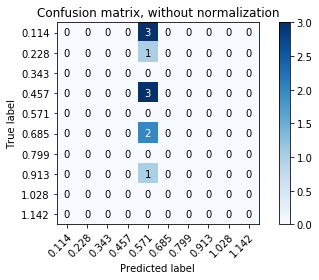

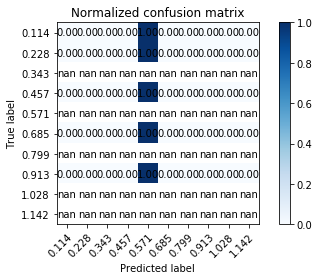

In [19]:
a6()

In [ ]:
import os
os.listdir('/Users/malavikavijayendravasist/Desktop/mt2/Checkpoints/trial/')

In [219]:
for i in range(10):
    s='soemthing'+"_{0:0ld}".format(134)
    print(s)

KeyError: 'i'

In [233]:
l=4
for i in range(10):     
    a="{:0"+str(l)+"d}"
    b=a.format(i)
    print(b)
    

0000
0001
0002
0003
0004
0005
0006
0007
0008
0009


In [ ]:
a='_{epoch:0ld}.h5'

In [245]:
a=18
c=0
while (a>0): 
    a//=10
    print(a)
    c+=1
    
print(c)


1
0
2


In [339]:
f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/CM.hdf5','r')
ytrue=f['ytrue'].value
ypred=f['ypred'].value
f.close()

f=h5py.File('/Users/malavikavijayendravasist/Desktop/mt2/high.hdf5','r')
high=f['high'].value
f.close()
cl=np.linspace(0,high,10+1) #self.feature_values doesnt include 0
cl=[round(i,3) for i in cl]
print(cl)
print(ytrue)
print(ypred)

[0.0, 0.114, 0.228, 0.343, 0.457, 0.571, 0.685, 0.799, 0.913, 1.028, 1.142]
[0.343 0.571 0.913 0.228 0.457 0.228 0.571 0.343 0.114 0.571]
[0.571 0.571 0.571 0.571 0.571 0.571 0.571 0.571 0.571 0.571]


In [340]:
def get_index(ytrue, ypred ): 
        
    index_ytrue=np.zeros(len(ytrue))
    index_ypred=np.zeros(len(ypred))
    
    for i in np.arange(len(ytrue)):
        index_ytrue[i]=np.where(ytrue[i]==cl)[0]-1
        index_ypred[i]=np.where(ypred[i]==cl)[0]-1
    print(index_ytrue,index_ypred)

In [341]:
get_index(ytrue,ypred)

[2. 4. 7. 1. 3. 1. 4. 2. 0. 4.] [4. 4. 4. 4. 4. 4. 4. 4. 4. 4.]
